In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import queue
import csv
from collections import OrderedDict
import re
import operator
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#import autotime

### Config

In [2]:
elements = {"C":12000, "H":1008, "O":15995, "N":14003, "S":31972}
atom_list = ['C', 'H', 'O']

#the order of neutral losses will be the same in the final output
neutral_losses = OrderedDict([("CH2", 14016), ("CH3", 15023), ("O", 15995), ("CH4", 16031),
                              ("H2O", 18010), ("CO", 27995), ("CH4O", 32026), ("CO2", 43990)])
alt_losses = OrderedDict([("C2H4", 28032), ("CH2O", 30011), ("C2H6", 30046), ("C2H2O", 42011), 
                          ("C3H6", 42047), ("C2H6O", 46042), ("C4H8", 56063), ("C2H4O2", 60021)])


input_file_path = '2D_MSMS_CHO_02_08_2021.xlsx'
# input_file_path = '2DMSMS_familyA_rawdata_05_18_2021.xlsx'
#input_file_path = 'testfunc.xlsx'
output_file_path = 'new_output.xlsx'

#precursor_mass = 391.103 #important: only up to 3 decimal points. 
#precursor_formula = OrderedDict([('C', 19), ('H', 19), ('O', 9)])

multiple = 4 #multiple of each neutral loss to consider to find the next peak
tolerance = 3 #tolerance of +-1mDa
nominal_tolerance = 1 # fragments within +-nominal_tolerance will be considered precursors.

In [3]:
print(neutral_losses.keys())
print(alt_losses.keys())

odict_keys(['CH2', 'CH3', 'O', 'CH4', 'H2O', 'CO', 'CH4O', 'CO2'])
odict_keys(['C2H4', 'CH2O', 'C2H6', 'C2H2O', 'C3H6', 'C2H6O', 'C4H8', 'C2H4O2'])


### Utility Functions

In [4]:
# get mass of a molecule given in dictionary form.
def get_mass(dic_formula):
    mass = 0
    for item in dic_formula.items():
        mass += elements[item[0]] * item[1]
    return mass

In [5]:
# get formula dictionary from string
def get_formula(formula, mol=atom_list):
    
    res = OrderedDict.fromkeys(mol, 0)  
    formula_list = re.findall(r'([A-Z][a-z]*)(-?\d*)', formula)
    for key, value in formula_list:
        res[key] = int(value) if value else 1
    
    return res

In [6]:
# calculate the difference between two formulas provided as dictionary with keys C, H, O
# formula_a - formula_b
def formula_diff(formula_a, formula_b, mol=atom_list):
    temp_a = OrderedDict()
    temp_b = OrderedDict()
    for atom in mol:
        temp_a[atom] = formula_a[atom] if atom in formula_a else 0
        temp_b[atom] = formula_b[atom] if atom in formula_b else 0
    
    diff_mol = OrderedDict()
    for atom in mol:
        diff_mol[atom] = temp_a[atom] - temp_b[atom]
    
    return diff_mol

In [7]:
# FIXME: standardize the formula. Add mol parameter.
def get_string_from_formula(formula):
    str_lst = []
    for element, count in formula.items():
        if count > 0:
            str_lst.append(str(element))
            str_lst.append(str(count))
    return ''.join([elem for elem in str_lst])

In [8]:
def string_diff(a, b, mol=atom_list):
    a_f = get_formula(a, mol)
    b_f = get_formula(b, mol)
    diff_f = formula_diff(a_f, b_f, mol)
    return get_string_from_formula(diff_f)

In [9]:
#get the atom count in mol (single letter atoms only C, H, O etc.)
def get_count(atom, mol):
    
    if atom not in mol:
        return 0
    
    count = mol.split(atom)[1]
    if len(count) == 0 or count[0].isalpha(): #if it's last element or the next element is a character
        return 1
    
    result = re.findall('\d+|$', mol.split(atom)[1])[0]
    return int(result) if result else 0

In [10]:
#get the core fragment int from a precursor formula dict and a dict of neutral loss counts
def get_core_int(nl_dict, precursor_formula):
    core_frag = []
    for element, count in precursor_formula.items():
        element_tot_count = 0
        for nl, _ in neutral_losses.items():
            element_nl_count = get_count(element, nl)
            element_tot_count += element_nl_count * nl_dict[nl]
            #if index == 0:
            #    print('Number of {}\'s in neutral loss {} = {} * {}'.format(element, nl, element_nl_count, row[nl]))
        
        # FIXME: "count - element_tot_count > 0" and "element_tot_count < count" is the same.
        if count - element_tot_count > 0 and element_tot_count < count:
            cho = str(count - element_tot_count)
            core_frag.append(cho if len(cho) == 2 else '0{}'.format(cho))
    
    return int(''.join(core_frag))

In [11]:
#get the core fragment string from a precursor formula dict and a dict of neutral loss counts
def get_core_string(nl_dict, precursor_formula):
    core_frag = []
    at_least_one = False
    for element, count in precursor_formula.items():
        element_tot_count = 0
        all_losses = OrderedDict()
        all_losses.update(neutral_losses)
        all_losses.update(alt_losses)
        for nl, _ in all_losses.items():
            element_nl_count = get_count(element, nl)
            element_tot_count += element_nl_count * nl_dict[nl]
            #if index == 0:
            #    print('Number of {}\'s in neutral loss {} = {} * {}'.format(element, nl, element_nl_count, row[nl]))
        
        
        # FIXME: "count - element_tot_count > 0" and "element_tot_count < count" is the same.
        if element_tot_count < count:
            at_least_one = True
            cho = str(count - element_tot_count)
            core_frag.append(element)
            core_frag.append(cho)
        
        if element_tot_count > count:
            raise ValueError(f"For precursor {get_string_from_formula(precursor_formula)} and pathway {nl_dict}, \
                             total count of element {element} is too large: {element_tot_count}.")
    if not at_least_one:
        raise ValueError(f"core_fragment return null")
    
    return ''.join(core_frag)


"""get the core fragment string from a precursor formula dict and a list of tuples of neutral loss counts"""
def get_core_string_2(nl_list, precursor_formula):
    """convert the list of tuples to dictionary and then call the get_core_string function."""
    keys = []
    keys.extend(neutral_losses.keys())
    keys.extend(alt_losses.keys())
    nl_dict = OrderedDict.fromkeys(keys, 0)
    for nl, count in nl_list:
        if nl in nl_dict:
            nl_dict[nl] += count
        else:
            raise KeyError(f"{nl} is not a valid neutral loss. \
                           Only the following neutral losses are accepted at the moment: {neutral_losses.keys()}")
            
    return get_core_string(nl_dict, precursor_formula)

In [12]:
#get a sequence of intermediate fragments from the sequence of neutral losses and precursor ion (dictionary).
def get_fragment_seq_from_nloss(nloss_seq, precursor_formula):
    current_fragment_formula = precursor_formula.copy()
    fragment_seq = []
    
    for nloss, count in nloss_seq:
        assert count > 0
        for _ in range(count):
            nloss_formula = get_formula(nloss)
            current_fragment_formula = formula_diff(current_fragment_formula, nloss_formula)
            
        current_fragment = get_string_from_formula(current_fragment_formula)
        fragment_seq.append(current_fragment)
    
    return fragment_seq

In [13]:
def is_path_valid(path, precursor_formula): 
    keys = []
    keys.extend(neutral_losses.keys())
    keys.extend(alt_losses.keys())
    nl_dict = OrderedDict.fromkeys(keys, 0)
    for nl, count in path:
        if nl in nl_dict:
            nl_dict[nl] += count
        else:
            raise KeyError(f"{nl} is not a valid neutral loss. \
                           Only the following neutral losses are accepted at the moment: {nl_dict.keys()}")
    is_valid = True
    for element, count in precursor_formula.items():
        element_tot_count = 0
        all_losses = OrderedDict()
        all_losses.update(neutral_losses)
        all_losses.update(alt_losses)
        for nl, _ in all_losses.items():
            element_nl_count = get_count(element, nl)
            element_tot_count += element_nl_count * nl_dict[nl]
        if element_tot_count > count:
            is_valid = False
    return is_valid

### Execution Starts Here:

In [14]:
# two_d_out = OrderedDict()
# precursor_list = []
# for name, spec in groups:
#     """
#     Traverse through each group. Each group contains one spectrum (with multiple precursors)
#     """
#     spec.reset_index(drop=True, inplace=True)
#     i = 0
#     while abs(spec.loc[i, 'fragments m/z'] - name) < 1:
#         """
#         Get each precursor within a spectrum. A precursor is any fragment ion within 1 Da range of nominal mass.
#         """
#         l_precursor_mass = int(round(spec.loc[i, 'fragments m/z'] * 1000))
#         #print('precursor: {}'.format(l_precursor_mass))
#         precursor_formula = spec.loc[i, 'Chemical formula']
#         if 'N' in precursor_formula:
#             i += 1
#             continue
        
#         #print('precursor: {}, mass: {}'.format(precursor_formula, l_precursor_mass))
#         precursor_list.append(precursor_formula)
#         i += 1
        
# precursor_list.sort(key=lambda x: get_mass(get_formula(x)))

In [18]:
df = pd.read_excel(input_file_path)
is_precursor = abs(df['Precursor m/z'] - df['fragments m/z']) < nominal_tolerance
precursor_data = df[is_precursor]

row_list = list(precursor_data['Chemical formula'])
row_list.sort(key=lambda x: get_mass(get_formula(x)))
row = [get_formula(x) for x in row_list]
masses = [get_mass(x) for x in row]
print(len(df))
print(len(precursor_data))

nominal_dict = {}
for _, l_row in precursor_data.iterrows():
    if l_row['Chemical formula'] not in nominal_dict:
        nominal_dict[l_row['Chemical formula']] = l_row['Precursor m/z']

9378
764


In [19]:
hoc = []
ooc = []
for dic in row:
    if 0.2 < dic['O'] / dic['C'] < 1.0:
        hoc.append(dic['H'] / dic['C'])
        ooc.append(dic['O'] / dic['C'])

756
756


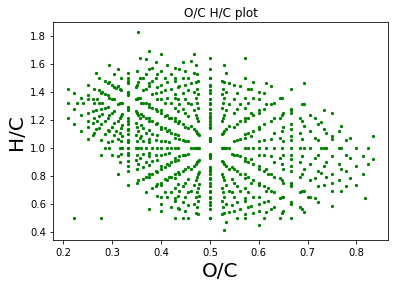

In [20]:
print(len(hoc))
print(len(ooc))
plt.scatter(ooc, hoc, s=5, c='green')
plt.ylabel('H/C', fontsize=20)
plt.xlabel('O/C', fontsize=20)
plt.title('O/C H/C plot')
plt.savefig('Van Krevelen_all_classes.png', dpi=600)
#highlight the chemical formula on hover
# color the 2d plot different for each pathway
# comparing pathways for different precursors sharing a core
## scoring the match between pathways.

In [18]:
# reg_dic = OrderedDict()
# for i in range(0, len(row)):
#     for j in range(i + 1, len(row)):
#         d = formula_diff(row[j], row[i])
#         d_mass = get_mass(d)
#         reg_chain = []
#         reg_chain.append(get_string_from_formula(row[i]))
#         reg_chain.append(get_string_from_formula(row[j]))
#         counter = 0
#         k_ = j
#         for k in range(j + 1, len(row)):
#             if formula_diff(row[k], row[k_]) == d:
#                 reg_chain.append(get_string_from_formula(row[k]))
#                 k_ = k
#                 counter += 1
        
#         # @Dennys: change the number to adjust the lower limit on the size of the regularity chain.
#         if len(reg_chain) >= 5:
#             masses.append(d_mass)
#             d_form = get_string_from_formula(d)
            
#             if d_form in reg_dic:
#                 if reg_chain not in reg_dic[d_form]: # Make sure we are not adding duplicate lists.
#                     reg_dic[d_form].append(reg_chain)
#             else:
#                 reg_dic[d_form] = [reg_chain]
            

In [19]:
# pd.DataFrame.from_dict(reg_dic, orient="index").to_csv("reg5_nocore_1.csv")

### Find the core-fragments and their pathways for each precursor.

In [21]:
#input_file_path = 'testfunc.xlsx'
df = pd.read_excel(input_file_path)
df = df.sort_values(['Precursor m/z', 'fragments m/z'], ascending=[True, False]).reset_index(drop=True)
#print(df)
groups = df.groupby('Precursor m/z', sort=False)

In [22]:
two_d_out = OrderedDict()
big_out = OrderedDict()
precursor_pathway_hist = []
oxygen_class_dist = []
o_len = 20
o_count = [0] * o_len

for name, spec in groups:
    """
    Traverse through each group. Each group contains one spectrum (with multiple precursors)
    """
    spec.reset_index(drop=True, inplace=True)
    i = 0
    while abs(spec.loc[i, 'fragments m/z'] - name) < nominal_tolerance:
        """
        Get each precursor within a spectrum. A precursor is any fragment ion within 1 Da range of nominal mass.
        """
        l_precursor_mass = int(round(spec.loc[i, 'fragments m/z'] * 1000))
        precursor_string = spec.loc[i, 'Chemical formula']
        precursor_formula = get_formula(precursor_string)
        
        #print('precursor: {}'.format(l_precursor_mass))
        
        l_spec = list(spec['fragments m/z'][i:])
        moz = np.round(np.asarray(l_spec) * 1000).astype(int)
        expanded_moz = np.zeros(np.amax(moz) + tolerance)
        expanded_moz[moz] = 1
        
        expanded_moz = np.convolve(expanded_moz, np.ones((tolerance,)), mode='valid')
        #print(np.sum(expanded_moz))

        for idx in range(len(expanded_moz)):
            expanded_moz[idx] = 1 if expanded_moz[idx] > 0 else 0   
    
        if expanded_moz[l_precursor_mass] != 1:
            print('precursor: {}'.format(l_precursor_mass))
            print("Invalid spectrum.")
            exit(1)
           
        pathways = queue.Queue(0)
        for loss, loss_mass in neutral_losses.items():
            nprecursor = l_precursor_mass
            
            for mul in range(multiple): #upto 5 neutral losses of one kind
                nprecursor -= loss_mass
                
                if nprecursor > 0 and nprecursor <= l_precursor_mass and expanded_moz[nprecursor] == 1:
                    new_mol = OrderedDict()    
                    new_mol["CoreMass"] = nprecursor
                    #new_mol["CoreFrag"] = ""
                    if loss == "CH2" and 5 > mul+1 > 1:
                        loss = "C{}H{}".format(mul+1, 2*(mul+1))
                        new_mol["path"] = [(loss, 1)]
                    else:
                        new_mol["path"] = [(loss, mul+1)]
                    pathways.put(new_mol)
                    #print(new_mol)
                    break
                    
        core_cand = OrderedDict()
        while not pathways.empty():
            mol = pathways.get()
            is_core = True
            found = {"CH2": False, "CH4": False, "CO": False, "H2O": False, "CH3": False, "CO2": False, "C2H4": False, "O": False, "CH4O": False}
            for loss, loss_mass in neutral_losses.items():
                tpmass = mol["CoreMass"]
                for mul in range(multiple):
                    tpmass -= loss_mass
                    if tpmass > 0 and tpmass <= l_precursor_mass and expanded_moz[tpmass] == 1:
                        nloss_found = False
                        new_mol = copy.deepcopy(mol)
                        new_mol["CoreMass"] = tpmass
                        if loss == "CH2":
                            if 5 > mul+1 > 1:
                                l_loss = "C{}H{}".format(mul+1, 2*(mul+1))
                                new_mol["path"].append((l_loss, 1))
                                nloss_found = True
                                if l_loss == "C2H4":
                                    found["C2H4"] = True
                            if mul+1 == 1:
                                if "CO" in new_mol["path"][-1]:
                                    del new_mol["path"][-1]
                                    new_mol["path"].append(("C2H2O", 1))
                                if "CH4" in new_mol["path"][-1]:
                                    del new_mol["path"][-1]
                                    new_mol["path"].append(("C2H6", 1))
                                if "H2O" in new_mol["path"][-1]:
                                    del new_mol["path"][-1]
                                    new_mol["path"].append(("CH4O", 1))
                                    found["CH4O"] = True
                                if "O" in new_mol["path"][-1]:
                                    del new_mol["path"][-1]
                                    new_mol["path"].append(("CH2O", 1))
                                if "CH4O" in new_mol["path"][-1]:
                                    del new_mol["path"][-1]
                                    new_mol["path"].append(("C2H6O", 1))
                                else:
                                    new_mol["path"].append(("CH2", 1))
                                    nloss_found = True
                                    found["CH2"] = True
                        else:
                            new_mol["path"].append((loss, mul+1))
                            nloss_found = True
                            if loss in found and mul+1 == 1:
                                found[loss] = True
                        if nloss_found:
                            is_core = False
                            pathways.put(new_mol)
                            break
                        
            for loss, loss_mass in alt_losses.items():
                tpmass = mol["CoreMass"] - loss_mass
                if tpmass > 0 and tpmass <= l_precursor_mass and expanded_moz[tpmass] == 1:
                    nloss_found = False
                    new_mol = copy.deepcopy(mol)
                    new_mol["CoreMass"] = tpmass
                    if loss == "C2H6" and not (found["CH3"] or found["CH2"] or found["CH4"]):
                        new_mol["path"].append((loss, 1))
                        nloss_found = True
                    if loss == "CH4O" and not (found["CH2"] or found["CH4"] or found["H2O"] or found["O"]):
                        new_mol["path"].append((loss, 1))
                        nloss_found = True
                    if loss == "C2H2O" and not(found["CO"] or found["CH2"]):
                        new_mol["path"].append((loss, 1))
                        nloss_found = True
                    if loss == "C2H6O" and not (found["CH4O"] or found["C2H4"] or found["H2O"]):
                        new_mol["path"].append((loss, 1))
                        nloss_found = True
                    if loss == "CH2O" and not (found["CH2"] or found["O"]):
                        new_mol["path"].append((loss, 1))
                        nloss_found = True
                    if nloss_found:
                        is_core = False
                        pathways.put(new_mol)
                        
            if is_core and expanded_moz[mol["CoreMass"]] == 1 and is_path_valid(mol["path"], precursor_formula):
                new_mol = copy.deepcopy(mol)
                #print(new_mol)
                key = ""
                for loss, mul in new_mol["path"]:
                    key += f"{mul}{loss} "
                key = key.strip(" ")

                if key not in core_cand:
                    if not is_path_valid(new_mol["path"], precursor_formula):
                        print(print("{} is not valid for precursor {}".format(new_mol["path"], get_string_from_formula(precursor_formula))))
                    core_cand[key] = new_mol

        #while not pathways.empty():
        #    print(pathways.get())
        print(spec.loc[i, 'Chemical formula'] + ' Number of possible combinations: ' + str(len(core_cand)))
        
        """Generate the histogram of number of pathways per precursor m/z"""
        precursor_pathway_hist.append([spec.loc[i, 'Precursor m/z'], len(core_cand)])
        
        """Get the oxygen group distribution."""
        tmp_o_count = get_formula(spec.loc[i, 'Chemical formula'])['O']
        if 0 <= tmp_o_count <= o_len:
            o_count[tmp_o_count] += len(core_cand)
        
        # Go through each pathways, get core-fragment, and fill the dictionary
        core_dict = OrderedDict()
        
        for key, nl_row in core_cand.items():
            core_str = get_core_string_2(nl_row["path"], precursor_formula)
            
            nl_row["path"] = get_fragment_seq_from_nloss(nl_row["path"], precursor_formula)
            
            if core_str in core_dict:
                core_dict[core_str][key] = nl_row
            else:
                tmp_dict = OrderedDict()
                tmp_dict[key] = nl_row
                core_dict[core_str] = tmp_dict
        
        big_out[precursor_string] = core_dict
        #print(precursor_string)
        #print(core_dict)
        
        i += 1

C15H17O4 Number of possible combinations: 1
C14H13O5 Number of possible combinations: 1
C13H9O6 Number of possible combinations: 1
C16H23O3 Number of possible combinations: 0
C15H19O4 Number of possible combinations: 0
C14H15O5 Number of possible combinations: 3
C13H11O6 Number of possible combinations: 3
C12H7O7 Number of possible combinations: 4
C14H17O5 Number of possible combinations: 2
C13H13O6 Number of possible combinations: 2
C12H9O7 Number of possible combinations: 12
C17H31O2 Number of possible combinations: 0
C15H23O4 Number of possible combinations: 0
C14H19O5 Number of possible combinations: 1
C13H15O6 Number of possible combinations: 10
C12H11O7 Number of possible combinations: 15
C17H33O2 Number of possible combinations: 0
C16H29O3 Number of possible combinations: 0
C14H21O5 Number of possible combinations: 20
C13H17O6 Number of possible combinations: 34
C12H13O7 Number of possible combinations: 26
C11H9O8 Number of possible combinations: 34
C16H31O3 Number of possible c

In [43]:
print("Total number of precursors: {}".format(len(big_out)))
pre_mass_num_core = []
num_cores = []
for pre, core_dict in big_out.items():
    pre_mass_num_core.append([get_mass(get_formula(pre))/1000, len(core_dict), pre])
    
pre_mass_num_core.sort(key=lambda x: x[0])
pre_mz, num_cores, pre = map(list, zip(*pre_mass_num_core))

Total number of precursors: 764


In [44]:
print(pre_mz[:10])
print(num_cores[:10])

[261.042, 261.079, 261.116, 263.021, 263.058, 263.095, 263.132, 263.169, 265.037, 265.074]
[1, 1, 1, 2, 3, 3, 0, 0, 5, 2]


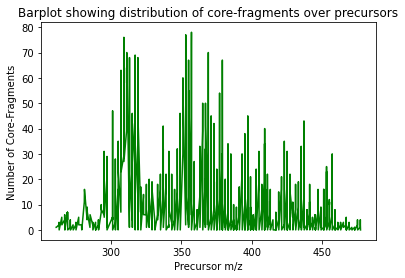

In [58]:
core_hist = list(zip(pre_mz, num_cores))
core_hist.sort(key = lambda x: x[1], reverse=True)
x, y = map(list, zip(*core_hist))
plt.plot(pre_mz, num_cores,color='green')
plt.ylabel('Number of Core-Fragments')
plt.xlabel('Precursor m/z')
plt.title('Barplot showing distribution of core-fragments over precursors')
plt.savefig('Cores_vs_Precursors.png', dpi=600)
f = open("core-vs-pre.csv", "a")
f.write("Precuresor ID, Precursor m/z, Number of Cores, Precursor Formula\n")
for pre_id, (l_pre_mz, l_num_cores, l_pre) in enumerate(zip(pre_mz, num_cores, pre)):
    f.write("{}, {}, {}, {}\n".format(pre_id, l_pre_mz, l_num_cores, l_pre))
f.close()

In [60]:
print(min(pre_mz), max(pre_mz))
print(sum(num_cores))

261.042 477.256
9021


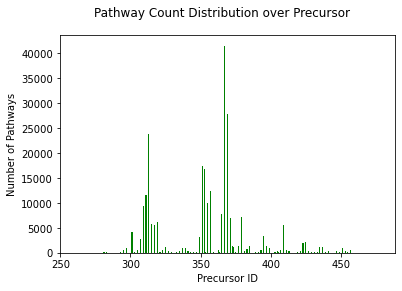

In [56]:
precursor_pathway_hist.sort(key = lambda x: x[0], reverse=False)
x, y = map(list, zip(*precursor_pathway_hist))
# y = np.clip(y, a_min=None, a_max=8000)
plt.bar(pre_mz, y, color='green')
plt.ylabel('Number of Pathways')
plt.xlabel('Precursor ID')
plt.suptitle('Pathway Count Distribution over Precursor')
plt.savefig('pathway_dist.png', dpi=600)
plt.show()
f = open("pathway-vs-pre.csv", "a")
f.write("Precursor ID, Precursor m/z, Number of Pathways, Precursor Formula\n")
for pre_id, (l_pre_mz, l_path, l_pre) in enumerate(zip(pre_mz, y, pre)):
    f.write("{}, {}, {}, {}\n".format(pre_id, l_pre_mz, l_path, l_pre))
f.close()

In [57]:
print(sum(y))

590022


[0, 0, 0, 0, 2538, 6459, 31207, 85483, 132354, 186181, 95562, 35677, 11225, 3151, 185, 0, 0, 0, 0, 0]
20
13


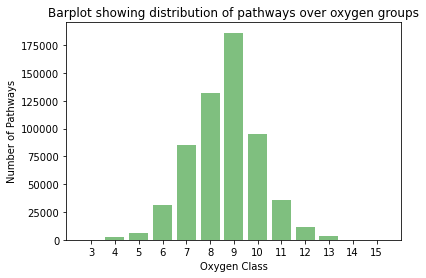

In [26]:
print(o_count)
print(len(o_count))
x_pos = range(3, 16)
print(len(x_pos))
labels = range(3, 16)
plt.bar(x_pos, o_count[3: 16], align='center', alpha=0.5,color='green')
plt.xticks(x_pos, labels)
plt.ylabel('Number of Pathways')
plt.xlabel('Oxygen Class')
plt.title('Barplot showing distribution of pathways over oxygen groups')
plt.savefig('oxygen_class.png', dpi=600)
plt.show()

In [27]:
i = 0
for pre, core_dict in big_out.items():
    print("pre: {}".format(pre))
    for core, core_path in core_dict.items():
        print("core: {}".format(core))
        print(core_path)
    if i > 10:
        break
    i += 1

pre: C15H17O4
core: C14H17O2
OrderedDict([('1CO2', OrderedDict([('CoreMass', 217123), ('path', ['C14H17O2'])]))])
pre: C14H13O5
core: C13H13O3
OrderedDict([('1CO2', OrderedDict([('CoreMass', 217087), ('path', ['C13H13O3'])]))])
pre: C13H9O6
core: C11H9O2
OrderedDict([('1CO2 1CO2', OrderedDict([('CoreMass', 173060), ('path', ['C12H9O4', 'C11H9O2'])]))])
pre: C16H23O3
pre: C15H19O4
pre: C14H15O5
core: C13H15O3
OrderedDict([('1CO2', OrderedDict([('CoreMass', 219102), ('path', ['C13H15O3'])]))])
core: C10H3O5
OrderedDict([('2CH4 1C2H4', OrderedDict([('CoreMass', 202998), ('path', ['C12H7O5', 'C10H3O5'])]))])
core: C10H7O3
OrderedDict([('2CH4 2CO', OrderedDict([('CoreMass', 175040), ('path', ['C12H7O5', 'C10H7O3'])]))])
pre: C13H11O6
core: C10H3O5
OrderedDict([('1CH4O 1C2H4', OrderedDict([('CoreMass', 202998), ('path', ['C12H7O5', 'C10H3O5'])]))])
core: C10H7O3
OrderedDict([('1CH4O 2CO', OrderedDict([('CoreMass', 175040), ('path', ['C12H7O5', 'C10H7O3'])]))])
core: C11H11O2
OrderedDict([('1

13


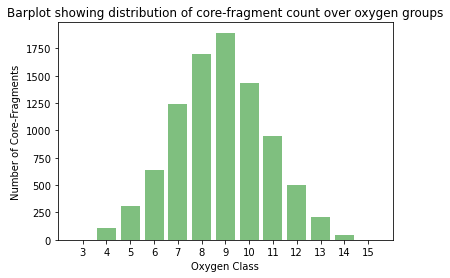

In [28]:
pre_mass_num_core = []
num_cores = []
o_len = 20
o_count = [0] * o_len
for pre, core_dict in big_out.items():
    if 'N' not in pre:
        o_count[get_formula(pre)["O"]] += len(core_dict)

x_pos = range(3, 16)
print(len(x_pos))
labels = range(3, 16)
plt.bar(x_pos, o_count[3: 16], align='center', alpha=0.5, color='green')
plt.xticks(x_pos, labels)
plt.ylabel('Number of Core-Fragments')
plt.xlabel('Oxygen Class')
plt.title('Barplot showing distribution of core-fragment count over oxygen groups')
plt.savefig('oxygen_class_over_core.png', dpi=600)
plt.show()

16


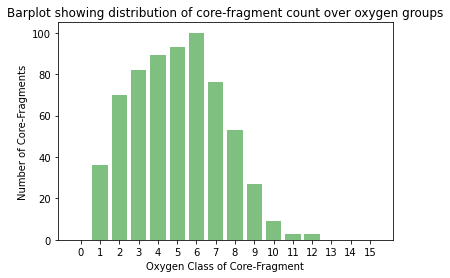

In [29]:
pre_mass_num_core = []
num_cores = []
core_set = set()
o_len = 20
o_count = [0] * o_len
for pre, core_dict in big_out.items():
    for core, core_path in core_dict.items():
        core_set.add(core)
        
for core in core_set:
    o_count[get_formula(core)["O"]] += 1

x_pos = range(0, 16)
print(len(x_pos))
labels = range(0, 16)
plt.bar(x_pos, o_count[0: 16], align='center', alpha=0.5, color='green')
plt.xticks(x_pos, labels)
plt.ylabel('Number of Core-Fragments')
plt.xlabel('Oxygen Class of Core-Fragment')
plt.title('Barplot showing distribution of core-fragment count over oxygen groups')
plt.savefig('oxygen_class_over_core.png', dpi=600)
plt.show()

precursor mass vs common core  
extend oxygen group vs pathways  
core mass vs number of pathways  
core mass vs number of precursors

In [30]:
# write to the excel file.
with open("big_out_frag_pathways.csv", "w", newline='') as f:
    fieldnames = ["Precursor", "Core-Fragment", "ID", "Pathway", "CoreMass"]
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for pre, cores in big_out.items():
        row = {}
        row["Precursor"] = pre
        for core, pathways in cores.items():
            row["Core-Fragment"] = core
            for ID, pathway in pathways.items():
                row["ID"] = str(ID)
                row["Pathway"] = pathway["path"]
                row["CoreMass"] = pathway["CoreMass"]
                #row.update(pathway)
                writer.writerow(row)
                row["Precursor"] = ""
                row["Core-Fragment"] = ""

In [31]:
big_out_df = pd.DataFrame([[pre, core, index, set(row["path"].copy()), row["path"].copy(), row["CoreMass"]] 
                           for pre in big_out.keys() 
                           for core in big_out[pre].keys()
                           for index, row in big_out[pre][core].items()],
                          columns=["Precursor", "Core-Fragment", "ID", "Path-Set", "Pathway", "Core-Mass"])
# big_out_df.set_index(["Precursor", "Core-Fragment", "ID"], inplace=True, verify_integrity=True)
big_out_df = big_out_df.astype({'Core-Mass': 'int32'})
big_out_df.drop(columns=["Path-Set"], inplace=True, axis=1)

In [32]:
big_out_df.to_csv("big_out_df_05-18-2021.csv")

In [39]:
big_out_df["Pre-Mass"] = [get_mass(get_formula(precursor)) for precursor in big_out_df["Precursor"]]
big_out_df.sort_values(by=["Pre-Mass"], inplace=True, ascending=True)
big_out_df.reset_index(drop=True, inplace=True)

In [39]:
big_out_df.iloc[50:100]

,Precursor,Core-Fragment,ID,Pathway,Core-Mass,Pre-Mass
50,C13H15O6,C8H3O4,1CO2 2CH4 1C2H4,"[C12H15O4, C10H7O4, C8H3O4]",163003,267090
51,C13H15O6,C8H3O4,2CH4 2CO 1CH4,"[C11H7O6, C9H7O4, C8H3O4]",163004,267090
52,C13H15O6,C11H11O3,1CH4O 1CO2,"[C12H11O5, C11H11O3]",191071,267090
53,C13H15O6,C8H4O4,2CH4 2CO 1CH3,"[C11H7O6, C9H7O4, C8H4O4]",164012,267090
54,C14H19O5,C13H19O3,1CO2,[C13H19O3],223134,267127
55,C11H9O8,C8H5O3,1CO2 1CO2 1O 1CH4,"[C10H9O6, C9H9O4, C9H9O3, C8H5O3]",149024,269032
56,C11H9O8,C7H3O4,1CO2 1CH2O 1CH2 1CH2 1O,"[C10H9O6, C9H7O5, C8H5O5, C7H3O5, C7H3O4]",149023,269032
57,C11H9O8,C7H3O4,1CO2 1CH2 1CH2O 1CH2 1O,"[C10H9O6, C9H7O6, C8H5O5, C7H3O5, C7H3O4]",149023,269032
58,C11H9O8,C7H3O3,2O 1CO2 1CH2 1CH2O 1CH2,"[C11H9O6, C10H9O4, C9H7O4, C8H5O3, C7H3O3]",149023,269032
59,C11H9O8,C9H9O2,1CO2 1CO2 1O 1O,"[C10H9O6, C9H9O4, C9H9O3, C9H9O2]",149060,269032


In [62]:
def overlap_size(path1, path2):
    len1 = len(path1)
    len2 = len(path2)
    
    min_len = min(len1, len2)
    path1 = path1[:min_len]
    path2 = path2[:min_len]
    
    overlap_count = 0
    for frag1, frag2 in zip(path1, path2):
        if frag1 == frag2:
            overlap_count += 1
        else:
            break
    
    return overlap_count

#### This part is new.

In [63]:
def get_key(row, overlap_len, key_offset):
    precursor = row["Precursor"]
    
    if len(row["Pathway"]) >= overlap_len:
        path = row["Pathway"][:overlap_len]
        short_key = False
    else:
        path = row["Pathway"]
        short_key = True
    
    if key_offset < 0:
        path = path[:key_offset]
    
    key = (precursor, tuple(path))
    return key, short_key

In [64]:
def in_graph(key, graph):
    if key in graph:
        return True, key, 0
    for i in range(len(key[1]) - 1):
        short_key = (key[0], key[1][:-(i+1)])
        if (short_key in graph) and (graph[short_key]["short-key"] == True):
            return True, short_key, -(i+1)
    return False, key, 0

In [65]:
def add_node(row, graph, overlap_len, key_offset, roots, is_root):
    key, short_key = get_key(row, overlap_len, key_offset)
    
    if key not in graph:
        graph[key] = {"core":row["Core-Fragment"], "pathway":row["Pathway"], "fnl":row["ID"].split(' ')[0], "short-key":short_key, "edges":set()}
        if is_root:
            roots.add(key)
    return key

In [66]:
def add_edge(key, parent_key, original_pathway, graph):
    assert parent_key in graph
    graph[parent_key]["edges"].add((key, original_pathway))

## This is the groundbreaking fast code :D

In [132]:
overlap_len = 2 # should be at least 2
path_forest = {}
roots = set()

fnl = ["1CO2", "1CH4O", "1H2O", "1CO"]

for index, row in big_out_df.iterrows():
    neutral_diff = row["ID"].split(' ')[0]
    if neutral_diff not in fnl:
        add_node(row, path_forest, overlap_len, key_offset=0, roots=roots, is_root=True)
        continue
        
    parent_prec = row["Pathway"][0]
    if len(row["Pathway"][1:]) >= overlap_len:
        parent_path = row["Pathway"][1:overlap_len+1]
    else:
        parent_path = row["Pathway"][1:]
        
    parent_key = (parent_prec, tuple(parent_path))
    parent_exists, parent_key, key_offset = in_graph(parent_key, path_forest)
    if parent_exists:
        key = add_node(row, path_forest, overlap_len, key_offset, roots, is_root=False)
        add_edge(key, parent_key, tuple(row["Pathway"]), path_forest)
    else:
        add_node(row, path_forest, overlap_len, key_offset=0, roots=roots, is_root=True)

In [133]:
print(len(path_forest))
print(len(roots))

5145
4574


#### The cells below find families and combine family isomers.

In [134]:
def populate_family_dict(path, path_forest, family_dict):
    family = []
    prec_list = []
    for node in path:
        row = path_forest[node[0]]
        out_row = [node[0][0], row["core"], list(node[1]), row["fnl"], node[0][1], row["short-key"]]
        prec_list.append(node[0][0])
        family.append(out_row)
    prec_id = tuple(prec_list)
    if prec_id in family_dict:
        family_dict[prec_id].append(family)
    else:
        family_dict[prec_id] = [family]

In [135]:
# this code is combining families with same set of precurosrs
family_counter = 0
family_dict = {}
for root in roots:
    if not path_forest[root]["edges"]:
        continue
    stack = [((root, tuple(path_forest[root]["pathway"])), None)]
    path = []
    while stack:
        node, _ = stack.pop()
        path.append(node)
        children = path_forest[node[0]]["edges"]
        if children:
            for child in children:
                stack.append((child, node))
        else:
            family_counter += 1
            populate_family_dict(path, path_forest, family_dict)
            path.pop()
            while stack and path[-1] != stack[-1][1]:
                path.pop()

In [136]:
family_output = []
for prec_id, family_group in family_dict.items():
    for prec in prec_id:
        family_output.append([prec, "", "", "", "", "", ""])
    for family in family_group:
        for row in family:
            family_output.append([""] + row)
        family_output.append(["", "", "", "", "", "", ""])
    family_output.append(["", "", "", "", "", "", ""])
    family_output.append(["", "", "", "", "", "", ""])

In [137]:
out_df = pd.DataFrame(family_output, columns=['Family-ID', 'Precursor', 'Core-Fragment', 'Pathway', 'Neutral-Loss', 'Overlap-Path', 'Short-Key'])
out_df.to_csv('CHO-core-match-grouped-dag.csv')

In [138]:
print(len(family_dict))

703


[928488, 165240, 147120, 107500, 105024, 81576, 72512, 71280, 67430, 63600, 49040, 39520, 39384, 34944, 34250, 25932, 25440, 23520, 22260, 20466, 19990, 19698, 18315, 17120, 16704, 16040, 15680, 15436, 14896, 13468, 13175, 13175, 12950, 11550, 11484, 10989, 9540, 8925, 8470, 8224, 7776, 7620, 7571, 7209, 7140, 7118, 7000, 6561, 6300, 6080, 6048, 5952, 5751, 5500, 5368, 5317, 5160, 5028, 4386, 4362, 4321, 4170, 4162, 4158, 4095, 4080, 4032, 3827, 3819, 3780, 3742, 3690, 3584, 3486, 3360, 3306, 3260, 3252, 3250, 3234, 2986, 2950, 2808, 2804, 2640, 2590, 2516, 2400, 2322, 2223, 2192, 2165, 2052, 2048, 1960, 1876, 1875, 1743, 1740, 1728, 1662, 1648, 1595, 1582, 1560, 1554, 1540, 1533, 1530, 1520, 1520, 1476, 1476, 1474, 1458, 1452, 1380, 1374, 1350, 1350, 1344, 1320, 1263, 1260, 1254, 1242, 1232, 1197, 1181, 1161, 1160, 1130, 1120, 1096, 1058, 1028, 1015, 949, 935, 935, 934, 889, 864, 840, 830, 828, 784, 768, 732, 728, 717, 685, 675, 652, 651, 651, 630, 615, 609, 600, 592, 585, 578, 576, 5

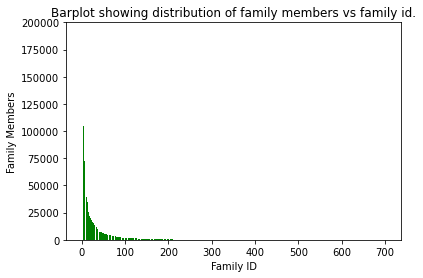

In [140]:
dist = []
for prec_id, family_group in family_dict.items():
    dist.append(len(family_group))
#     if len(family_group) > 20000:
#         print(prec_id)
dist.sort(reverse=True)
print(dist)
# dist = dist[:20]
plt.bar(range(len(dist)), dist, align='center', color='green')
plt.ylim((0, 200000))
# plt.xticks(x_pos, labels)
plt.ylabel('Family Members')
plt.xlabel('Family ID')
plt.title('Barplot showing distribution of family members vs family id.')

plt.savefig('family-member-dist.png', dpi=600)
plt.show()

In [88]:
g_set    = set()
pre_set  = set()
core_set = set()
all_set  = set()

i = 0
family_id = 0
for prec_id, family_group in family_dict.items():
    family_pres = list(prec_id)
    
    for pre in prec_id:
        pre_set.add(pre)
    
    for f in range(len(family_pres) - 1, 0, -1):
        g_set.add((family_pres[f], family_pres[f-1], string_diff(family_pres[f], family_pres[f-1]), family_id))
        
#     for family in family_group:
#         for line in family:
#             core_set.add(line[1])
            
#             prev = line[0]
#             for j in range(len(line[2])):
#                 frag = line[2][j]
#                 all_set.add(frag)
#                 g_set.add((prev, frag, string_diff(prev, frag), family_id))
#                 prev = frag
                
    family_id += 1

In [89]:
g_lst = list(g_set)
df = pd.DataFrame(g_lst, columns =['source', 'target', 'neutral_loss', 'family_id'])
df.to_csv('family-graph.csv', index=False)

12


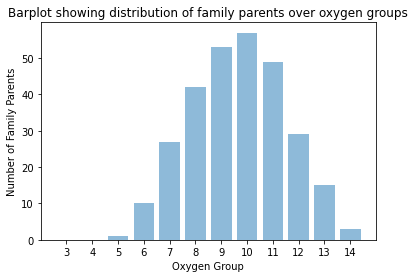

[0, 0, 0, 0, 0, 1, 10, 27, 42, 53, 57, 49, 29, 15, 3, 0, 0, 0, 0, 0]


In [93]:
prev = ""
curr = ""
parents = set()
for family_id in family_dict:
    parents.add(family_id[-1])

o_len = 20    
o_count = [0] * o_len
parents = set(parents)
for pre in parents:
    if 'N' not in pre:
        o_count[get_formula(pre)["O"]] += 1

x_pos = range(3, 15)
print(len(x_pos))
labels = range(3, 15)
plt.bar(x_pos, o_count[3: 15], align='center', alpha=0.5)
plt.xticks(x_pos, labels)
plt.ylabel('Number of Family Parents')
plt.xlabel('Oxygen Group')
plt.title('Barplot showing distribution of family parents over oxygen groups')

plt.savefig('family-parent-over-oxygen-group.png', dpi=600)
plt.show()
print(o_count)

[0, 0, 371, 117, 26, 3, 0, 0, 0, 0]


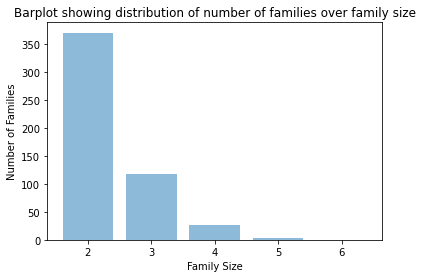

In [119]:
size = 0
sizes = [0] * 10
for family_id in family_dict:
    size = len(family_id)
    sizes[size] += 1

print(sizes)

x_pos = range(2, 7)
y = sizes[2: 7]
labels = range(2, 7)
plt.bar(x_pos, y, align='center', alpha=0.5)
plt.xticks(x_pos, labels)
plt.ylabel('Number of Families')
plt.xlabel('Family Size')
plt.title('Barplot showing distribution of number of families over family size')

plt.savefig('number-of-families-over-family-size.png', dpi=600)
plt.show()

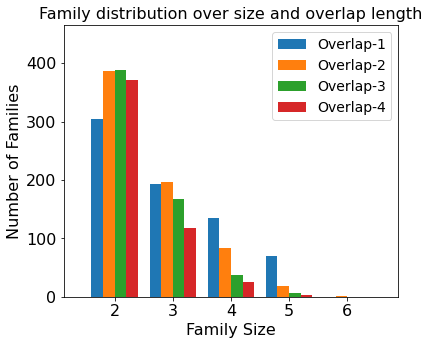

In [131]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['2', '3', '4', '5', '6']
one = [304, 194, 135, 70, 0]
two = [386, 196, 83, 19, 1]
three = [388, 167, 38, 7, 0]
four = [371, 117, 26, 3, 0]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
rects1 = ax1.bar(x - width*1.5, one, width, label='Overlap-1')
rects2 = ax1.bar(x - width/2, two, width, label='Overlap-2')
rects3 = ax1.bar(x + width/2, three, width, label='Overlap-3')
rects4 = ax1.bar(x + width*1.5, four, width, label='Overlap-4')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Number of Families', fontsize=16)
ax1.set_xlabel('Family Size', fontsize=16)
ax1.set_title('Family distribution over size and overlap length', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=16)
ax1.tick_params(axis='both', labelsize=16)
# ax1.set_ylim([0,140])
ax1.legend(prop={'size': 14})
ax1.margins(0.1, 0.2)


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax1.annotate('{}k'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom', fontsize=12)


# autolabel(rects1)
# autolabel(rects2)

plt.subplots_adjust(wspace=0.1)
plt.savefig('fam-size-dist.png', dpi=600, bbox_inches='tight')
plt.show()

In [95]:
print("Total number of Precursors: {}".format(len(set(big_out_df["Precursor"]))))
print("Precursors in families: {}".format(len(pre_set)))

Total number of Precursors: 602
Precursors in families: 437


In [82]:
total_cores = 0
nom_core = {}
for pre, cores in big_out.items():
    nom_mz = nominal_dict[pre]
    for core in cores:        
        if nom_mz not in nom_core:
            nom_core[nom_mz] = set()
        nom_core[nom_mz].add(core)

for _, core_set in nom_core.items():
    total_cores += len(core_set)
print("Total number of Cores: {}".format(total_cores))

nom_core = {}
family_cores = 0
for prec_id, family_group in family_dict.items():
    for family in family_group:
        for row in family:
            nom_mz = nominal_dict[row[0]]
            if nom_mz not in nom_core:
                nom_core[nom_mz] = set()
            nom_core[nom_mz].add(row[1])
            
for _, core_set in nom_core.items():
    family_cores += len(core_set)
print("Cores in families: {}".format(family_cores))

Total number of Cores: 3538
Cores in families: 948


In [77]:
pre_set = set()
core_set = set()
for pre, cores in big_out.items():
    pre_set.add(pre)
    for core, frags in cores.items():
        core_set.add(core)
        
total_frags = 0
nom_frag = {}
for pre, cores in big_out.items():
    nom_mz = nominal_dict[pre]
    pre_frag_set = set()
    for core, paths in cores.items():
        for nl, path in paths.items():
            for frag in path["path"]:
#                 if frag not in pre_set and frag not in core_set:
                if nom_mz not in nom_frag:
                    nom_frag[nom_mz] = set()
                nom_frag[nom_mz].add(frag)
                    
for _, pre_frag_set in nom_frag.items():
    total_frags += len(pre_frag_set)
print("Total fragments: {}".format(total_frags))

family_frags = 0
nom_frag = {}
for prec_id, family_group in family_dict.items():
    pre_frag_set = set()
    for family in family_group:
        for row in family:
            nom_mz = nominal_dict[row[0]]
            for frag in row[2]:
#                 if frag not in pre_set and frag not in core_set:
                if nom_mz not in nom_frag:
                    nom_frag[nom_mz] = set()
                nom_frag[nom_mz].add(frag)

for _, pre_frag_set in nom_frag.items():
    family_frags += len(pre_frag_set)
print("Fragments in families: {}".format(family_frags))

Total fragments: 9984
Fragments in families: 4165


In [51]:
pre_set = set()
core_set = set()
for pre, cores in big_out.items():
    pre_set.add(pre)
    for core, frags in cores.items():
        core_set.add(core)
        
total_frags = 0
for pre, cores in big_out.items():
    pre_frag_set = set()
    for core, paths in cores.items():
        for nl, path in paths.items():
            for frag in path["path"]:
                if frag not in pre_set and frag not in core_set:
                    total_frags += 1
print("Total fragments: {}".format(total_frags))

family_frags = 0
for prec_id, family_group in family_dict.items():
    pre_frag_set = set()
    for family in family_group:
        for row in family:
            for frag in row[2]:
                if frag not in pre_set and frag not in core_set:
                    family_frags += 1
print("Fragments in families: {}".format(family_frags))

Total fragments: 133631
Fragments in families: 9647


#### Ignore the cells below

In [ ]:
g_set    = set()
pre_set  = set()
core_set = set()
all_set  = set()

i = 0
family_id = 0
while i < len(output):
    line = output[i]
    i += 1
    
    family_pres  = []
    while line[0]:
        pre_set.add(line[0])
        core_set.add(line[1])
        
        family_pres.append(line[0])
        prev = line[0]
        for j in range(len(line[2])):
            frag = line[2][j]
            all_set.add(frag)
            g_set.add((prev, frag, string_diff(prev, frag), family_id))
            prev = frag
        line = output[i]
        i += 1
    
    for f in range(len(family_pres) - 1, 0, -1):
        g_set.add((family_pres[f], family_pres[f-1], string_diff(family_pres[f], family_pres[f-1]), family_id))
    
    i += 1
    family_id += 1

In [ ]:
#use this function if want to ignore original pathway.
def print_path2(path, path_forest, output, overlap_len):
    prev = []
    for node in path:
        row = path_forest[node]
        if prev:
            first  = row["pathway"][:overlap_len] if len(row["pathway"]) >= overlap_len else row["pathway"]
            second = prev[overlap_len - 1:] if len(prev) >= overlap_len else []
            path   =  first + second
        else:
            path = row["pathway"]
        prev = path
        out_row = [node[0], row["core"], path, row["fnl"], node[1], row["short-key"]]
        print(out_row)
        output.append(out_row)
    print(["", "", "", "", "", ""])
    output.append(["", "", "", "", "", ""])

### Below THREE cells are for listing out families only. They don't combine familiy isomers.

In [ ]:
def print_path(path, path_forest, output):
    for node in path:
        row = path_forest[node[0]]
        out_row = [node[0][0], row["core"], list(node[1]), row["fnl"], node[0][1], row["short-key"]]
        print(out_row)
        output.append(out_row)
    print(["", "", "", "", "", ""])
    output.append(["", "", "", "", "", ""])

In [ ]:
output = []
family_counter = 0
for root in roots:
    if not path_forest[root]["edges"]:
        continue
    stack = [((root, tuple(path_forest[root]["pathway"])), None)]
    path = []
    while stack:
        node, _ = stack.pop()
        path.append(node)
        children = path_forest[node[0]]["edges"]
        if children:
            for child in children:
                stack.append((child, node))
        else:
            family_counter += 1
            print_path(path, path_forest, output)
            path.pop()
            while stack and path[-1] != stack[-1][1]:
                path.pop()

In [ ]:
out_df = pd.DataFrame(output, columns=['Precursor', 'Core-Fragment', 'Pathway', 'Neutral-Loss', 'Overlap-Path', 'Short-Key'])
out_df.to_csv('CHO-overlap-3-dag.csv')